# Inhibitory-stabilized rate sequence network

Now stabilized under modulatory input.

$$J_{i+1, i}(t) = J_0(1 + w_iu(t))$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from my_stats import get_cmn_p
from disp import set_plot

cc = np.concatenate

N = 350
X_MIN = -20
X_MAX = 340
RX = np.linspace(X_MIN, X_MAX, N)
RT = np.arange(0, 1.5, .001)

DT = .00005

def relu(h):
    return np.where(h > 0, h, 0)

In [2]:
def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PiYG', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c='k') for x in xs]
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('auto')
    set_plot(ax, x_label='t', y_label='x')

In [3]:
TAU = .01
M_0 = .5
BETA = 2
phi_z = lambda r: np.exp(BETA*(np.mean(r) - M_0))


def smlt(t, r_0, J_0, J_Z, W, u_fn):
    W_MAT = np.diag(W[:-1], -1)
    rs = np.nan*np.zeros((len(t), N))
    rs[0, :] = r_0.copy()
    
    hs = np.nan*np.zeros((len(t), N))
    hs[0, :] = r_0.copy()

    zs = np.nan*np.zeros((len(t), 1))
    zs[0, :] = phi_z(rs[0, :])
    
    u = np.nan*np.zeros(len(t))
    u[0] = u_fn(t[0])

    for ct, t_ in enumerate(t[1:], 1):
        
        u_ = u_fn(t_)
        
        J = J_0*(1 + W_MAT*u_)
        dh = (DT/TAU)*(-hs[ct-1, :] + J@rs[ct-1, :] + J_Z@zs[ct-1, :])
        h = hs[ct-1, :] + dh
        hs[ct, :] = h.copy()
        
        rs[ct, :] = relu(h)

        z = phi_z(rs[ct, :])
        zs[ct, :] = [z]
        
        u[ct] = u_
        
    return rs, u, zs

In [4]:
U_FN = lambda t_: .5*(1+signal.square(2*np.pi*(t_-.1)/.6, duty=.3))  # non-negative square wave modulation
J_0s = []
Ws = []

# spatially constant, square wave temporal modulation
J_0 = 10*np.diag(np.ones(N-1), -1)
W = -.1*np.ones(N)
J_Z = -0.05*np.ones((N, 1))

In [5]:
def update_w(w, t, rs, u, r_th=10, delta=0):
    atvy = (rs.T > r_th)
    
    # take time integral of each neuron's activation times shifted input
    ishift = int(np.round(delta/DT))
    u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
        
    mx = (atvy@u_shifted > 0)
    w_new = w.copy()
    w_new[mx] = -.8
    
    # forgetting
    w_new[~mx] = -.1
    
    return w_new, atvy, mx

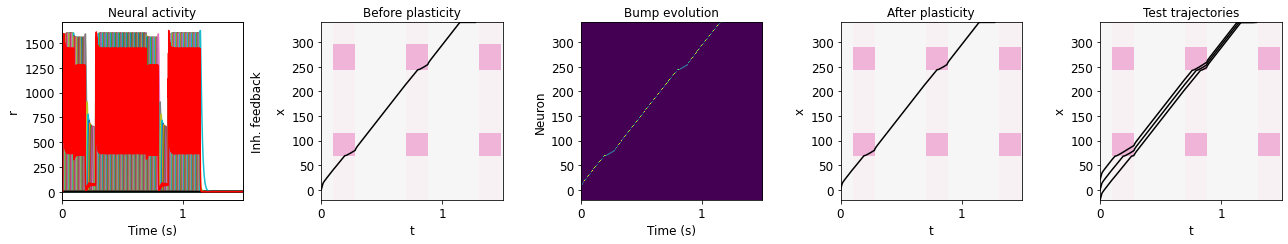

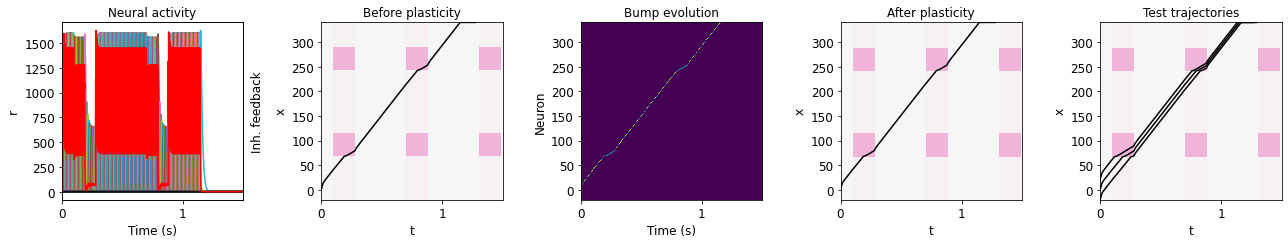

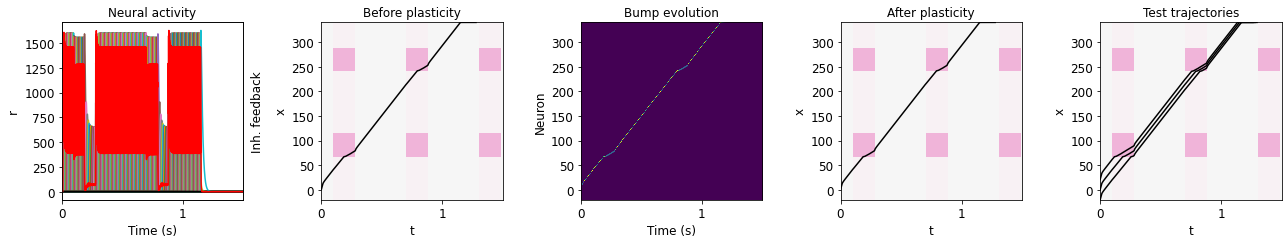

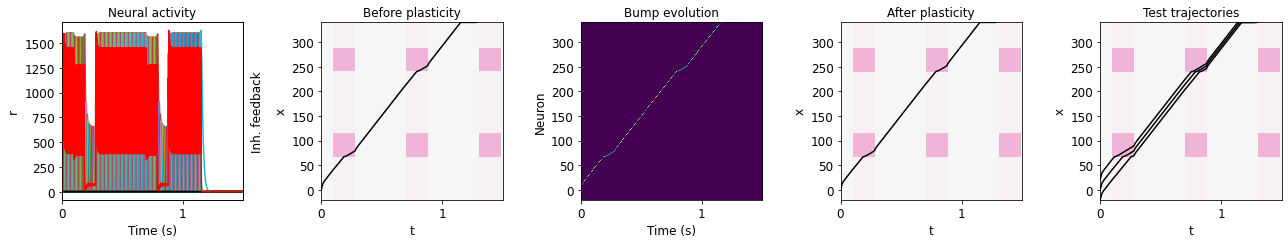

In [13]:
t = np.arange(0, 1.5, DT)
R_0 = np.eye(N)[20, :]

R_0_TESTs = [
    np.eye(N)[20, :],
    np.eye(N)[0, :],
    np.eye(N)[40, :],
]

for ctr in range(4):
    
    rs, u, zs = smlt(t, R_0, J_0, J_Z, W, U_FN)
    ps = np.array([r/np.sum(r) for r in rs])
    x_mn = np.array([RX@p for p in ps])
    
    # update w
    W_NEW, _, _ = update_w(W, t, rs, u, r_th=10, delta=.1)
    
    rs_tests = []
    x_mn_tests = []
    
    for r_0_test in R_0_TESTs:
        
        rs_test, _, _ = smlt(t, r_0_test, J_0, J_Z, W_NEW, U_FN)
        ps_test = np.array([r/np.sum(r) for r in rs_test])
        x_mn_test = np.array([RX@p for p in ps_test])
        
        rs_tests.append(rs_test.copy())
        x_mn_tests.append(x_mn_test.copy())

    fig, axs = plt.subplots(1, 5, figsize=(18, 3.5), tight_layout=True, sharex=True)
    axs = axs.flatten()
    axs[0].plot(t, rs)
    axs[0].plot(t, rs[:, 0], c='k', lw=2)
    set_plot(axs[0], x_label='Time (s)', y_label='r', title='Neural activity')
    
    ax_twin = axs[0].twinx()
    ax_twin.plot(t, zs[:, 0], c='r')
    set_plot(ax_twin, y_ticks=[], y_label='Inh. feedback')

    plot_trj(axs[1], U_FN, W, t=t, xs=[x_mn], cscale=.5)
    set_plot(axs[1], title='Before plasticity')
    
    axs[2].matshow(rs.T, origin='lower', extent=[t[0], t[-1], RX[0], RX[-1]])
    axs[2].set_aspect('auto')
    axs[2].xaxis.tick_bottom()
    set_plot(axs[2], x_label='Time (s)', y_label='Neuron', title='Bump evolution')
    
    plot_trj(axs[3], U_FN, W_NEW, t=t, xs=[x_mn], cscale=.5)
    set_plot(axs[3], title='After plasticity')
    
    plot_trj(axs[4], U_FN, W_NEW, t=t, xs=x_mn_tests, cscale=.5)
    set_plot(axs[4], title='Test trajectories')
    
    W = W_NEW